In [8]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

tfk = tf.keras
tfd = tfp.distributions
tfb = tfp.bijectors
tfkl = tf.keras.layers
tfpl = tfp.layers

import matplotlib.pyplot as plt

How to build and calibrate models of stochastic processes arising from SDEs with Keras

## Stochastic differential equations
A [stochastic process](https://en.wikipedia.org/wiki/Stochastic_process) is a sequence of random variables $X_t$ indexed by a time parameter $t$ that can be discrete or continuous. The dynamics of a continuous process is often described by a [stochastic differential equation](https://en.wikipedia.org/wiki/Stochastic_differential_equation) of the form

$$
dX_t = \mu(X_t, t)dt + \sigma(X_t, t)dW_t.
$$

For certain special cases of $\mu(X_t, t)$ and $\sigma(X_t, t)$, that include standard and geometric Brownian motions, the solution $X_t$ follows a normal distribution with parameters given by some integrals. In general, one relies instead on numerical approximations, for instance the [Euler–Maruyama method](https://en.wikipedia.org/wiki/Euler%E2%80%93Maruyama_method) that generates approximated samples of the process $X_t$ at discretized time steps $t_1, \dots, t_N$,

$$
X_{i+1} = X_i + \mu(X_i, t_i)\Delta t_i + \sigma(X_i, t_i)\,\sqrt{\Delta t_i}\, Z_i, \quad Z_i \sim \mathcal{N}(0,1).
$$

In TensorFlow Probability, this is conveniently implemented as a `tfd.MarkovChain` distribution.

In [2]:
growth = .1
volatility = .2
time_step = .02
n_steps = 501

geom_brownian_motion = tfd.MarkovChain(
            initial_state_prior=tfd.Deterministic(1.),
            transition_fn=lambda _, x: tfd.Normal(
                loc=x + x * growth * time_step,
                scale=x * volatility * tf.sqrt(time_step)),
            num_steps=n_steps,
            name='geometric_brownian_motion')

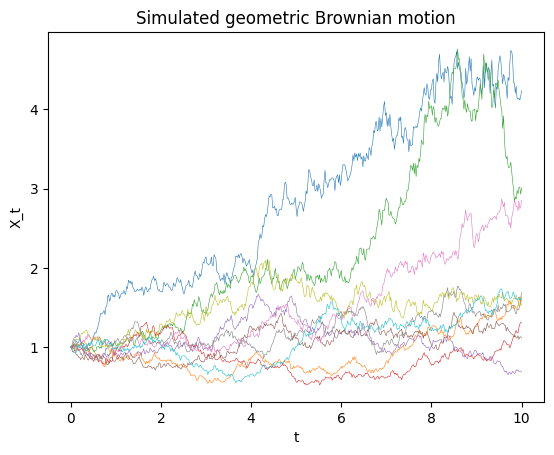

In [3]:
n = 500
time = tf.linspace(0., (n_steps-1)*time_step, n_steps)
s = geom_brownian_motion.sample(n)
for i in range(10):
    plt.plot(time, s[i], linewidth=.4)
plt.title('Simulated geometric Brownian motion')
plt.xlabel('t')
plt.ylabel('X_t')
plt.show()

This is usually good enough for Monte Carlo methods, but sometimes one needs to know the probability density function at a given time $t$, for instance in inference problems with models that have a stochastic process component.





Markov chain could work, but intermediate steps that need to be marginalized out


In [4]:
t = tf.stack(s.shape[0]*[time], axis=0)[:,1:]
X = s[:, 1:]

t = tf.reshape(t, (-1, 1))
X = tf.reshape(X, (-1, 1))

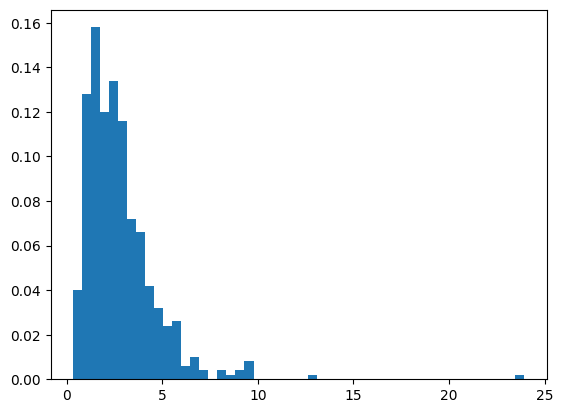

In [5]:
plt.hist(s[:,-1], bins=50, weights=tf.ones(s.shape[0])/s.shape[0])
plt.show()

In [9]:
# Conditional density estimation with MADE.
made = tfb.AutoregressiveNetwork(
  params=2,
  hidden_units=[16, 16],
  event_shape=(1,),
  conditional=True,
  kernel_initializer=tfk.initializers.VarianceScaling(0.1, seed=42),
  conditional_event_shape=(1,)
)

distribution = tfd.TransformedDistribution(
  distribution=tfd.Sample(tfd.Normal(loc=0., scale=0.001),
                          sample_shape=(1,)),
  bijector= tfb.Chain([tfb.Exp(), tfb.MaskedAutoregressiveFlow(made, name='maf')])
)

# Construct and fit a model.
X_ = tfkl.Input(shape=(X.shape[-1],), dtype=tf.float32)
t_ = tfkl.Input(shape=(t.shape[-1],), dtype=tf.float32)
log_prob_ = distribution.log_prob(
  X_, bijector_kwargs={'maf': {'conditional_input': t_}})
model = tfk.Model([X_, t_], log_prob_)

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.003),
              loss=lambda _, log_prob: -log_prob)

batch_size = 50

history = model.fit(x=[X, t],
                    y=np.zeros((X.shape[0], 0), dtype=np.float32),
                    batch_size=batch_size,
                    epochs=50,
                    steps_per_epoch=X.shape[0] // batch_size,
                    shuffle=True,
                    verbose=False)

KeyboardInterrupt: 

In [ ]:
plt.plot(history.history['loss'][1:])

In [ ]:
xx = distribution.sample(5, bijector_kwargs={'maf': {'conditional_input': tf.ones((1,1), tf.float32)}})

In [ ]:
sample_space = tf.linspace(0.0, 20, 100)
density = distribution.prob(sample_space[...,None], bijector_kwargs={'maf': {'conditional_input':10*tf.ones((1,1), tf.float32)}})

In [ ]:
plt.hist(s[:,-1], bins=50, weights=tf.ones(s.shape[0])*2/s.shape[0])
plt.plot(sample_space, density)

In [ ]:
s.shape

In [ ]:
sample_space = tf.linspace(0.0, 10, 100)
for i in range(10):
    density = distribution.prob(sample_space[...,None], bijector_kwargs={'maf': {'conditional_input':(i+1)*tf.ones((1,1), tf.float32)}})
    plt.plot(sample_space, density, linewidth=0.5)
plt.show()

In [ ]:
sample_space = tf.linspace(0.0, 10, 100)
for i in range(10):
    density = distribution.prob(sample_space[...,None], bijector_kwargs={'maf': {'conditional_input':0.1*(i+1)*tf.ones((1,1), tf.float32)}})
    plt.plot(sample_space, density, linewidth=0.5)
plt.show()

In [ ]:
dist = tfd.LogNormalogNormal(